# <center> Практика. EDA + Feature Engineering. Соревнование на Kaggle </center>

### **Постановка задачи:**

**ИССЛЕДОВАНИЕ ДАННЫХ:**

✍ В этом модуле мы будем работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую мы будем обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

***ДАННЫЕ САЙТА BOOKING:***

Наименование столбца:  | Описание столбца:
------- | --------
***hotel_address***   | адрес отеля;
***review_date***   | дата, когда рецензент разместил соответствующий отзыв;
***average_score***   | средний балл отеля, рассчитанный на основе последнего комментария за последний год;
***hotel_name***   | название отеля;
***reviewer_nationality***   | страна рецензента;
***negative_review***   | отрицательный отзыв, который рецензент дал отелю;
***review_total_negative_word_counts***   | общее количество слов в отрицательном отзыв;
***positive_review***   | положительный отзыв, который рецензент дал отелю;
***review_total_positive_word_counts***   | общее количество слов в положительном отзыве.
***reviewer_score***   | оценка, которую рецензент поставил отелю на основе своего опыта;
***total_number_of_reviews_reviewer_has_given***   | количество отзывов, которые рецензенты дали в прошлом;
***total_number_of_reviews***   | общее количество действительных отзывов об отеле;
***tags***   | теги, которые рецензент дал отелю;
***days_since_review***   | количество дней между датой проверки и датой очистки;
***additional_number_of_scoring***   | есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
***lat***   | географическая широта отеля;
***lng***   | географическая долгота отеля.

***Содержание работы:***

1. Импорт библиотек и загрузка данных.
2. Очистка данных.
3. Исследование данных.
4. Генерация признаков.
5. Преобразование признаков.
6. Отбор признаков.
7. Обучение модели.

## **1. Импорт библиотек и загрузка данных:**

In [18]:
# Загружаем необходимые библиотеки:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [104]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [105]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [2]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [108]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [110]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [111]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [112]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [3]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score,
# мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [115]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

In [116]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                                1
lng                                                1
sample                                             2
reviewer_score                                    38
dtype: int64

<AxesSubplot:>

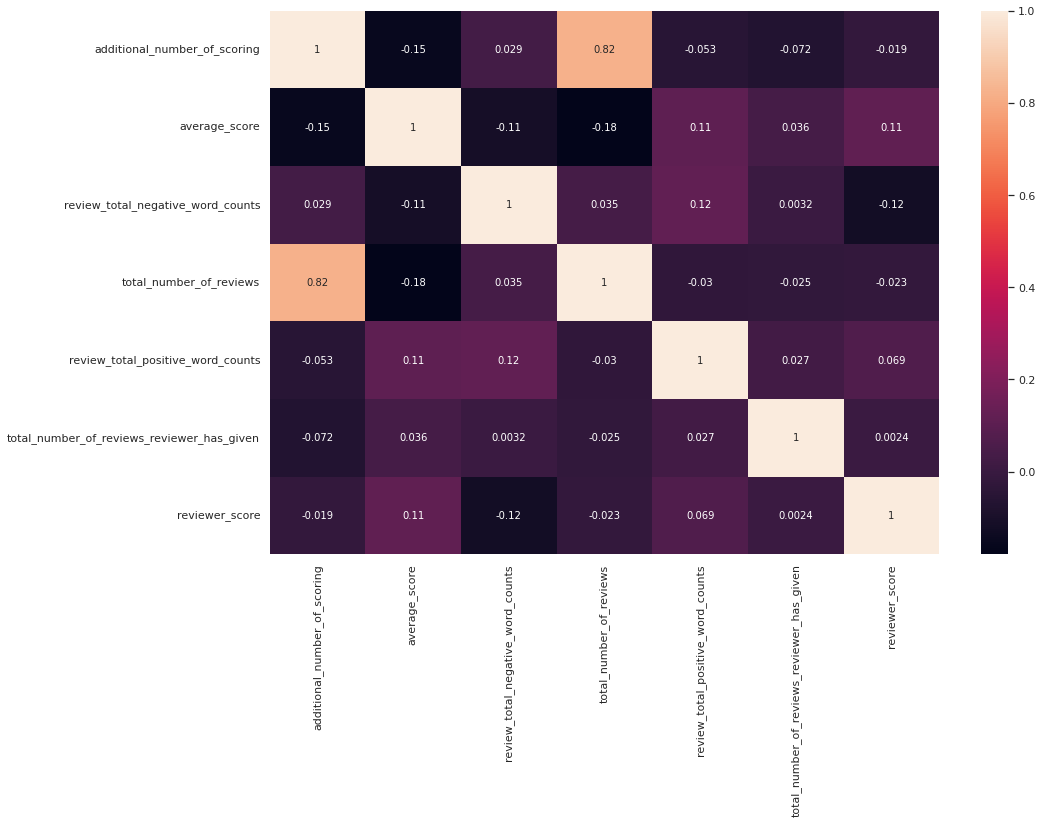

In [117]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

### ***Вывод:*** в датасете 515738 записей (есть пропущенные значения).

## **2. Очистка данных:**

2.1. Проверим данные на наличие дубликатов и удалим найденные дубликаты:

In [118]:
print('В датасете в тренировочной выборке: {} дубликатов.'.format(df_train[df_train.duplicated()].shape[0]))
print('В датасете в тестовой выборке: {} дубликатов.'.format(df_test[df_test.duplicated()].shape[0]))

df_train.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов в тренировочной выборке составляет: {}.'.format(df_train.shape[0]))

В датасете в тренировочной выборке: 307 дубликатов.
В датасете в тестовой выборке: 29 дубликатов.
Количество строк после удаления дубликатов в тренировочной выборке составляет: 386496.


### ***Вывод:*** найдены дубликаты в обеих частях датасета мы проведем удаление дубликатов, только в тренировочной выборке (представленные данные содержат 307 дубликатов), т.к. тестовая выборка фиксирована и ее изменять нельзя по правилам соревнования на kaggle. Количество строк после удаления дубликатов в тренировочной выборке составляет 386496.

## **3. Исследование данных:**

3.1. Классифицируем все признаки на числовые и категориальные:

***Категориальные признаки:***
1. hotel_address
2. review_date
3. hotel_name
4. reviewer_nationality
5. negative_review
6. positive_review
7. tags
8. days_since_review

***Числовые признаки:***
1. additional_number_of_scoring
2. average_score
3. review_total_negative_word_counts
4. total_number_of_reviews
5. review_total_positive_word_counts
6. total_number_of_reviews_reviewer_has_given
7. lat
8. lng
9. sample
10. reviewer_score

3.2. Выведем на экран основные статистические характеристики
данных по каждому числовому признаку:

In [119]:
data.describe(include = 'all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738,515738,0,0,515738.000000,515738.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,55242,731,0,0,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,5101,2585,NaN,NaN,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,NaN,NaN,NaN,NaN,0.749999,6.297672
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,NaN,NaN,NaN,NaN,0.433014,3.902295
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,NaN,NaN,NaN,NaN,0.250000,0.625000
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,NaN,NaN,NaN,NaN,1.000000,7.900000
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,NaN,NaN,NaN,NaN,1.000000,9.600000


### **Вывод:** с помощью метода describe() определили основные статистические характеристики для каждого из признаков.

## **4. Генерация признаков:**

4.1. Иследуем признак hotel_address и создадим новые признаки 'country' и 'city':

In [120]:
# Создание нового признака 'country':

data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] 
        if x.split()[-1] != 'Kingdom' 
        else ' '.join(x.split()[-2:]))

print('\n В датасете представлены отели из '+ str(data['country'].nunique()) + ' стран:\n')
print(data['country'].value_counts())


 В датасете представлены отели из 6 стран:

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64


In [121]:
# Создание нового признака 'city':

data['city'] = data.apply(lambda x: x['hotel_address'].split()[-5] 
        if x['country'] == 'United Kingdom'
        else x['hotel_address'].split()[-2], axis=1)

print('\n В датасете представлены отели из '+ str(data['city'].nunique()) + ' городов:\n')
print(data['city'].value_counts())


 В датасете представлены отели из 6 городов:

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64


4.2. Приведем дату отзыва к формату datetime:

In [64]:
data['review_date'] = pd.to_datetime(data['review_date']).dt.date

# Выделим год, месяц, квартал из даты отзыва:

data['review_year'] = pd.to_datetime(data['review_date']).dt.year
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_quarter'] = pd.to_datetime(data['review_date']).dt.quarter

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



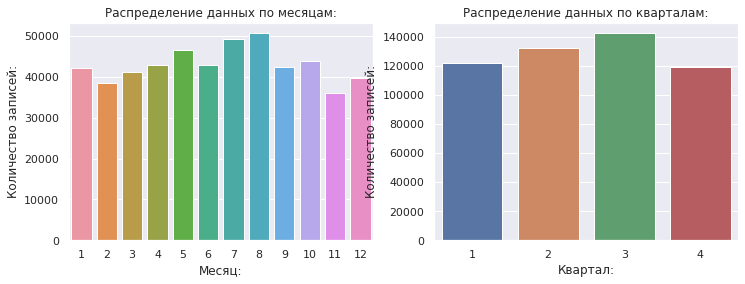

In [68]:
# Выделим сеззоность оценок:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.countplot(data['review_month'], ax=axes[0]);
axes[0].set(xlabel='Месяц:', ylabel='Количество записей:')
axes[0].set_title('Распределение данных по месяцам:')

sns.countplot(data['review_quarter'],  ax=axes[1]);
axes[1].set(xlabel='Квартал:', ylabel='Количество записей:')
axes[1].set_title('Распределение данных по кварталам:')
fig.show()

## **6. Отбор признаков:**

6.1. Определим в данных неинформативные признаки, которые не будут участвовать в исследовании:

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет,
# просто выберим их и удалим:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

## **7. Обучение модели**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)